# Theory

## Problem

### Statement

Using information from the set of labelled documents(size *n*) to label the unlabelled(size *m*) ones.

### Solution

1. Build dictionary of words(size: *k*) from the labelled documents.
2. Using the dictionary and one of below techniques, create the vectors of the documents both from labelled and unlabelled set:
    * One hot encoding
    * Bag of Words
    * Tf-Idf
    * Word Embeddings
3. Then using vectors take one of the approach:
    * Document Similarity:
        * Works with any number of documents.
        * Compute similarity metric of how each document from labelled set relates to each one from the unlabelled set. This is done generaly by *cosine similarity* and prodces a matrix of size(*n x m*)
        * Get the index of maximum similarity score which gives the closest document from the unlabelled one to the labelled one. Eg: An index [3][7] will depict that the 7th unlabelled document is closest to 3rd labelled document. Hence belongs to the same category as the 3rd one.
        * Assign the category as the closest document belongs to.
    * Machine Learning:
        * Works with large number of labelled documents, since more number of samples will let the classifier converge better.
        * Train a classifier on vectors and target variable as the label of the labelled documents.
        * Use the model on the vectors of unlabelled documents.



## Key Terminology

### N-Grams

Before creating a dictionary and further analysis, a set of adjacent words to be used in combination has to be defined. Called **N-Grams** where *N* represents number of adjacent words in document to consider.

Since now each element in the dictionary formed has n-grams, all further stages will consider these n-grams.

Generally n-grams are considered to find a pattern in the text. A use case detecting *Plagiarism* by applicants during screening, where different documents are compared and if a pettern is noticed, that raises a flag showing a case of cheating.

### Dictionary

Generally the dictioanry is prepared by:
* Removing all the words that don't hold semantic information i.e. *stopwords* such as "a", "the", "is", "was", etc.
* Removing all special characters.
* Combining the remaining words.
* Removing the duplicate words.

Now the dictionary prepared is used for further analysis.


### Vectorization

A vector is prepared for each document and is of same size as of the dictionary prepared.

1. One Hot Encoding(OH):
    * Shows the presence(1) or absence(0) of a word or an n-gram from dictionary, in the document.
    * Each document is represented in binary form. Eg: [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]
2. Bag of Words(BOW):
    * Shows the number of times the word or an n-gram from dictionary, appeared in the document.
    * Each document is represented in integral form. Eg: [2, 1, 0, 5, 3, 4, 0, 0, 1, 2, 1, 1, 1, 5]
3. Term Frequency: $tf = \frac{n_{matched}}{n_{total}}$ 
    * Where $n_{matched}$ are the number of words in the document present in the dictionary and $n_{total}$ is the number of words in the document.
    * Each document is represented in fractional form. Eg: [0.023, 0.12, 0.543, 0.569]
    * Depicts an importance of a word from dictonary across the document.
4. Intermediate Document Frequency: $idf=\ln{\frac{N_{total}}{N_{matched}}}$
    * Where $N_{total}$ is total number of documents in the corpus and $N_{matched}$ is the total number of documents in the corpus that contain the words from the dictionary.
    * Hence is a vector of size, same as of the dictonary
    * Depicts an importance of a word from dictionary across the corpus.
    * Multiplying it with $tf$ gives the complete picture of the importance of the keywords both from the perspective of a document and the corpus.
    * Hence tf-idf saves some amount of semantic information, that was ignored in OH and BOW.
5. Embeddings:
    * The best technique to create vectors with the semantic information preserved.
    * While creating vectors of the document using keywords from dictionary, each keyword is further distributed to another number of dimentions *d* specified.
    * Due to this a document is converted to a matrix(size: *n x d*) rather than a vector.




# Problem Solving

## Data Overview

In [ ]:
from pandas import read_csv

raw_train = read_csv("/content/sample_data/predict_category/train.txt",encoding="utf-8")
raw_test = read_csv("/content/sample_data/predict_category/test.txt",encoding="utf-8")

In [ ]:
print("train".upper())
raw_train.head()

TRAIN


,url,scrap_tag,element,value,filename,category,source
0,https://www.thehindu.com/business/indias-boomi...,div,id,content-body,1.txt,business,the hindu
1,https://www.thehindu.com/news/national/kerala/...,div,id,content-body,2.txt,business,the hindu
2,https://www.thehindu.com/business/agri-busines...,div,id,content-body,3.txt,business,the hindu
3,https://www.thehindu.com/sport/cricket/icc-wor...,div,id,content-body,4.txt,sports,the hindu
4,https://www.thehindu.com/sport/football/argent...,div,id,content-body,5.txt,sports,the hindu


In [ ]:
print("test".upper())
raw_test.head()

TEST


,url,scrap_tag,element,value,filename,category,source
0,https://timesofindia.indiatimes.com/india/the-...,div,class,_3YYSt clearfix,1.txt,national,toi
1,https://indianexpress.com/article/india/vijay-...,div,id,pcl-full-content,2.txt,national,indianexpress
2,https://indianexpress.com/article/entertainmen...,div,id,pcl-full-content,3.txt,entertainment,indianexpress
3,https://indianexpress.com/article/entertainmen...,div,id,pcl-full-content,4.txt,entertainment,indianexpress
4,https://indianexpress.com/article/sports/footb...,div,id,pcl-full-content,5.txt,sports,indianexpress


Observe that there is no text in train.txt, just *links* and *location* in the form of elements with particular tags, class, ids, etc given.

All this implies that first we need to create pipeline for data preparation, move on with the text analysis and then document classification. 

Hence, the following stages:
1. Data Preparation
    * Scraping data
    * Filtering data
        * Removing html tags
        * Removing stop words
        * Lemmatization
    * Saving data
2. Text Analysis
    * Vectorization
        * BOW
        * TF-IDF
        * Embedding
3. Classification
    * Document similarity based on vectors
        * BOW
        * TF-IDF
        * Embedding
    * Classification
    * Comparing vectorization techniques



## Data Preparation

### Scraping Data

Before going on with iteration for scraping all articls, lets examine how to use the location tags given.

In [ ]:
raw_train.loc[0]

url          https://www.thehindu.com/business/indias-boomi...
scrap_tag                                                  div
element                                                     id
value                                             content-body
filename                                                 1.txt
category                                              business
source                                               the hindu
Name: 0, dtype: object

Visiting the url and using dev tools of browser

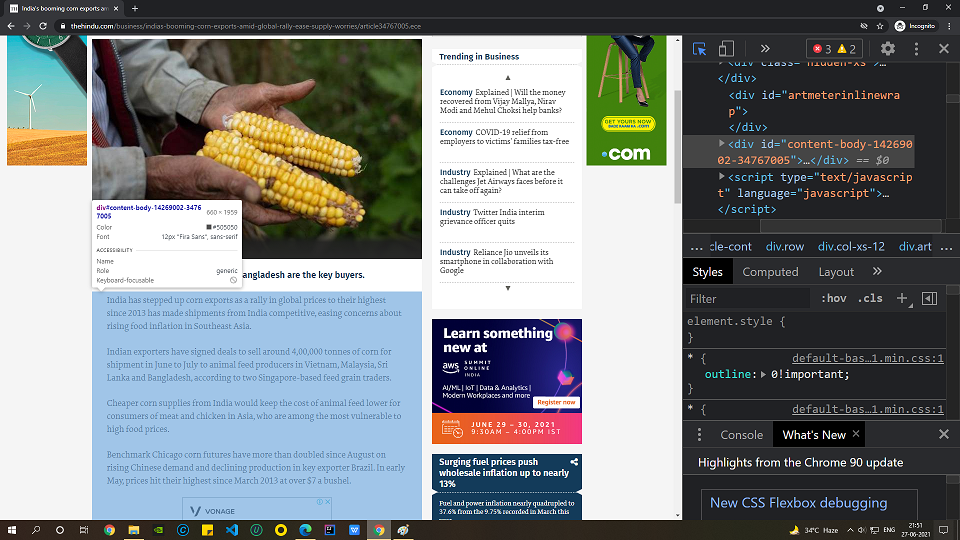

The given element location points to the text as highlighted above. Observe that the id as found is *content-body-14269002-34767005* but the given value is *content-body*. Such discrepancies can be handled using regex.

Hence, we need to atleast visit all unique URLs and observe such things. Then we need to make a regex pattern that will support all the location values given in train.

For this case, the known part is the initial part then anything can come up. Also there is only one element with that id as provided.

In [ ]:
# Fetching data for single URL
import requests
import regex
from bs4 import BeautifulSoup

content = requests.get(raw_train.at[0,"url"])
soup = BeautifulSoup(content.text, "html")
print(str(soup.find(
    raw_train.at[0,"scrap_tag"], 
    {   raw_train.at[0,"element"] : regex.compile(raw_train.at[0,"value"]+".*")})
))

<div id="content-body-14269002-34767005">
<p> India has stepped up corn exports as a rally in global prices to their highest since 2013 has made shipments from India competitive, easing concerns about rising food inflation in Southeast Asia.</p><p>Indian exporters have signed deals to sell around 4,00,000 tonnes of corn for shipment in June to July to animal feed producers in Vietnam, Malaysia, Sri Lanka and Bangladesh, according to two Singapore-based feed grain traders.</p><p>Cheaper corn supplies from India would keep the cost of animal feed lower for consumers of meat and chicken in Asia, who are among the most vulnerable to high food prices.</p><p>Benchmark Chicago corn futures have more than doubled since August on rising Chinese demand and declining production in key exporter Brazil. In early May, prices hit their highest since March 2013 at over $7 a bushel.</p><p>“India has been active with cargoes being shipped to Vietnam and Malaysia,” said one of the sources, a Singapore-ba

Wow! regex pattern worked. Let's use the same pattern for other URLs.

### Pipeline

In [ ]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Creating pipeline to scrap, filter and save the documents

In [ ]:
from string import punctuation
from pandas import DataFrame
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def scrap_transform(dataset: DataFrame):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    dataset["text"] = ""
    
    for idx,row in dataset.iterrows():
        content = requests.get(row["url"])
        soup = BeautifulSoup(content.text, "html")
        
        # Scraping Articles
        article = str(soup.find(row["scrap_tag"], {row["element"]: regex.compile(row["value"]+".*")}))

        # Removing HTML tags
        article = regex.sub("<.*?>","",article)

        # Replacing new line and converting to lowercase
        article = article.replace("\n", " ").lower()

        # Removing punctuations
        article = [word for word in article.split(" ") if word not in [chr for chr in punctuation]]

        # Removing stopwords
        article = [word for word in article if word not in nltk.corpus.stopwords.words("english")]

        # Lemmatization
        article = [lemmatizer.lemmatize(word) for word in article]

        # Save to dataframe
        row["text"] = " ".join(article)
        
        print("Scrapped and transformed article - '{}'".format(row["url"]))

In [ ]:
print("Articles - Train".upper())
scrap_transform(raw_train)
raw_train.head()

ARTICLES - TRAIN
Scrapped and transformed article - 'https://www.thehindu.com/business/indias-booming-corn-exports-amid-global-rally-ease-supply-worries/article34767005.ece'
Scrapped and transformed article - 'https://www.thehindu.com/news/national/kerala/farmers-at-stake-as-fertiliser-prices-go-up/article34497487.ece'
Scrapped and transformed article - 'https://www.thehindu.com/business/agri-business/govt-sets-record-1043-million-tonne-rice-production-target-for-2021-22-kharif-season/article34449163.ece'
Scrapped and transformed article - 'https://www.thehindu.com/sport/cricket/icc-world-test-championship-final-india-vs-new-zealand-fifth-day-report-southampton/article34904601.ece'
Scrapped and transformed article - 'https://www.thehindu.com/sport/football/argentina-qualify-for-copa-quarters-with-win-over-paraguay/article34897886.ece'
Scrapped and transformed article - 'https://www.thehindu.com/sport/athletics/hubbard-is-first-trans-athlete-at-olympics/article34894809.ece'
Scrapped and

,url,scrap_tag,element,value,filename,category,source,text
0,https://www.thehindu.com/business/indias-boomi...,div,id,content-body,1.txt,business,the hindu,india stepped corn export rally global price...
1,https://www.thehindu.com/news/national/kerala/...,div,id,content-body,2.txt,business,the hindu,farmer across state grappling dwindling crop ...
2,https://www.thehindu.com/business/agri-busines...,div,id,content-body,3.txt,business,the hindu,government friday set record rice production...
3,https://www.thehindu.com/sport/cricket/icc-wor...,div,id,content-body,4.txt,sports,the hindu,india 64 two 30 over second inning stump fift...
4,https://www.thehindu.com/sport/football/argent...,div,id,content-body,5.txt,sports,the hindu,argentina ensured place quarter-finals copa ...


In [ ]:
print("Articles - Test".upper())
scrap_transform(raw_test)
raw_test.head()

ARTICLES - TEST
Scrapped and transformed article - 'https://timesofindia.indiatimes.com/india/the-coronavirus-outbreak/india/will-consider-insurance-cover-to-workers-performing-last-rites-of-covid-victims-centre-tells-sc/articleshow/83718603.cms'
Scrapped and transformed article - 'https://indianexpress.com/article/india/vijay-rupani-unveils-policy-for-e-vehicles-with-subsidies-7371013/'
Scrapped and transformed article - 'https://indianexpress.com/article/entertainment/hollywood/meryl-streep-the-accent-queen-a-quick-look-at-her-mastery-over-it-in-5-videos-7368874/'
Scrapped and transformed article - 'https://indianexpress.com/article/entertainment/television/indian-idol-12-javed-akhtar-says-arunita-reminds-him-of-lata-mangeshkar-7370651/'
Scrapped and transformed article - 'https://indianexpress.com/article/sports/football/kumi-yokoyama-japan-comes-out-as-transgender-man-7370825/'
Scrapped and transformed article - 'https://indianexpress.com/article/sports/golf/anirban-lahiri-grabs-la

,url,scrap_tag,element,value,filename,category,source,text
0,https://timesofindia.indiatimes.com/india/the-...,div,class,_3YYSt clearfix,1.txt,national,toi,new delhi: centre told supreme court monday wo...
1,https://indianexpress.com/article/india/vijay-...,div,id,pcl-full-content,2.txt,national,indianexpress,chief minister vijay rupani tuesday announced...
2,https://indianexpress.com/article/entertainmen...,div,id,pcl-full-content,3.txt,entertainment,indianexpress,"secret meryl streep wonderful actor, deeply c..."
3,https://indianexpress.com/article/entertainmen...,div,id,pcl-full-content,4.txt,entertainment,indianexpress,javed akhtar set grace upcoming episode india...
4,https://indianexpress.com/article/sports/footb...,div,id,pcl-full-content,5.txt,sports,indianexpress,japan women’s international forward kumi yoko...


In [ ]:
# Null Checks
print("train".upper() + "\n{}".format(raw_train.isnull().sum()))
print("\ntest".upper() + "\n{}".format(raw_test.isnull().sum()))

TRAIN
url          0
scrap_tag    0
element      0
value        0
filename     0
category     0
source       0
text         0
dtype: int64

TEST
url          0
scrap_tag    0
element      0
value        0
filename     0
category     0
source       0
text         0
dtype: int64


This implies all articles have been scrapped successfully.

## Text Analysis

Before Vectorization we need to create a corpus of documents.

In [ ]:
from numpy import ndarray

class Vectorized:
    features: list
    vectors: ndarray

In [ ]:
def vectorize(vectorizer, corpus):
    vectorized = Vectorized()
    transformed = vectorizer.fit_transform(corpus)
    vectorized.features = vectorizer.get_feature_names()
    vectorized.vectors = transformed.toarray()
    print("features".upper() + " - {}".format(vectorized.features))
    print("Shape - {}\n{}".format(vectorized.vectors.shape, vectorized.vectors))
    return vectorized

### Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

print("train".upper())
train_bow = vectorize(CountVectorizer(), raw_train["text"])

print("\ntest".upper())
test_bow = vectorize(CountVectorizer(vocabulary=train_bow.features), raw_test["text"])

TRAIN
FEATURES - ['00', '000', '02', '08', '09', '10', '101', '102', '103', '104', '104b', '10th', '11', '114', '117', '12', '12b', '13', '134', '135', '147', '147th', '149', '15', '151', '153b', '16', '162', '16b', '16th', '17', '170', '177', '177b', '18', '180', '185', '19', '192', '1991', '1st', '1x1', '1x4', '1x6', '20', '200', '2011', '2013', '2017', '2018', '2019', '2020', '2021', '20th', '21', '217', '22', '221', '23', '234', '23b', '24', '249', '25', '26', '27', '28', '29', '295', '2nd', '2x4', '2x6', '30', '300', '307', '30b', '31', '32', '330', '33b', '34', '35', '36', '37', '37b', '387', '3b', '3x4', '40', '43', '445', '454', '46', '46b', '48', '49', '50', '500', '51', '53', '54', '55b', '57', '5b', '60', '60s', '61', '62', '628', '63', '64', '65', '656', '661', '68', '69', '69th', '6x4', '70', '73', '75', '76', '80', '81b', '82', '84', '841', '86', '87', '88', '8b', '90', '92', '93', '94', '95', '96', '99', '999', 'aadmi', 'aam', 'aap', 'aayog', 'ability', 'able', 'absence'

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("train".upper())
train_tfidf = vectorize(TfidfVectorizer(), raw_train["text"])

print("\ntest".upper())
test_tfidf = vectorize(TfidfVectorizer(vocabulary=train_bow.features), raw_test["text"])

TRAIN
FEATURES - ['00', '000', '02', '08', '09', '10', '101', '102', '103', '104', '104b', '10th', '11', '114', '117', '12', '12b', '13', '134', '135', '147', '147th', '149', '15', '151', '153b', '16', '162', '16b', '16th', '17', '170', '177', '177b', '18', '180', '185', '19', '192', '1991', '1st', '1x1', '1x4', '1x6', '20', '200', '2011', '2013', '2017', '2018', '2019', '2020', '2021', '20th', '21', '217', '22', '221', '23', '234', '23b', '24', '249', '25', '26', '27', '28', '29', '295', '2nd', '2x4', '2x6', '30', '300', '307', '30b', '31', '32', '330', '33b', '34', '35', '36', '37', '37b', '387', '3b', '3x4', '40', '43', '445', '454', '46', '46b', '48', '49', '50', '500', '51', '53', '54', '55b', '57', '5b', '60', '60s', '61', '62', '628', '63', '64', '65', '656', '661', '68', '69', '69th', '6x4', '70', '73', '75', '76', '80', '81b', '82', '84', '841', '86', '87', '88', '8b', '90', '92', '93', '94', '95', '96', '99', '999', 'aadmi', 'aam', 'aap', 'aayog', 'ability', 'able', 'absence'

### Embeddings

Word embeddings can be learned from methods:
* Word2Vec
* GloVe
* Embedding layer from ANN

The last method is a slower approach, but tailors the model to a specific training dataset and made with following stages:
* One Hot representation of the documents.
* Padding of the converted sparse vectors to create vectors of equal lengths suitable for deep learning.
* Creating a sequential model with an embedding layer.


In [ ]:
from tensorflow.keras.preprocessing.text import one_hot

train_OH = []
for idx,row in raw_train.iterrows():
    train_OH.append(one_hot(row["text"],len(train_bow.features)))

print("Length : {}".format(len(train_OH)))
print("First Element: {}".format(train_OH[0]))

Length : 15
First Element: [167, 11, 1361, 1153, 1645, 386, 244, 792, 1549, 672, 170, 2049, 167, 1877, 1189, 1168, 1915, 1094, 1861, 369, 1423, 277, 1691, 3, 543, 1386, 380, 1413, 127, 1107, 1630, 1361, 2049, 293, 1947, 2140, 1433, 1061, 1062, 1249, 1340, 153, 363, 219, 281, 1109, 1488, 1433, 1376, 1847, 765, 1361, 638, 167, 972, 2249, 435, 2140, 1433, 2293, 2127, 1120, 1772, 1423, 228, 2179, 149, 1094, 1619, 1925, 937, 1361, 1893, 1908, 1549, 994, 1915, 436, 1837, 1653, 17, 1014, 1691, 1984, 1368, 1860, 244, 109, 792, 1549, 493, 672, 292, 1814, 433, 983, 1766, 1112, 1062, 1249, 1601, 479, 550, 1756, 1109, 1488, 210, 1486, 1376, 285, 1492, 82, 1340, 153, 2157, 1792, 277, 1361, 1852, 2145, 344, 1896, 647, 1766, 1361, 839, 673, 946, 1630, 2122, 435, 363, 2160, 1481, 1808, 1229, 369, 1423, 1698, 1215, 1630, 2160, 1481, 1808, 344, 1702, 1361, 281, 285, 1355, 479, 957, 638, 1927, 765, 344, 1077, 587, 2049, 1773, 1094, 884, 2183, 2293, 244, 363, 1601, 249, 71, 167, 1158, 8, 746, 1376, 836, 4

All the items represents indices in the vocabulary created from the documents by One Hot representation. Each of the member in the list is of different length, hence before passing it to a deep learning model each item should be transformed to same length. Hence *padding* is required.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

embedded_train = pad_sequences(train_OH, padding="pre", maxlen=max(list(map(lambda x : len(x), train_OH))))
print("Shape : [{},{}]".format(len(embedded_train), len(embedded_train[0])))
print("First Element: {}".format(embedded_train[0]))

Shape : [15,703]
First Element: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

# No. of features such as Gender, Royal, Wood, etc. that generally an embedding layer makes
dimension = 50
model = Sequential(
    Embedding(len(train_bow.features), dimension, input_length=len(embedded_train[0]))
)
model.compile("adam", "mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 703, 50)           117700    
Total params: 117,700
Trainable params: 117,700
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_embedding = model.predict(embedded_train)
print("Embedded first doc : {}".format(train_embedding[0]))

Embedded first doc : [[ 0.00782583  0.01197667  0.04533776 ...  0.03082952 -0.00110459
  -0.01825999]
 [ 0.00782583  0.01197667  0.04533776 ...  0.03082952 -0.00110459
  -0.01825999]
 [ 0.00782583  0.01197667  0.04533776 ...  0.03082952 -0.00110459
  -0.01825999]
 ...
 [-0.01152797 -0.00566605 -0.01375066 ... -0.00373916  0.03157756
  -0.01757538]
 [ 0.00800254  0.02963494 -0.03916935 ...  0.03982352 -0.04190005
  -0.02493917]
 [ 0.00996877  0.01137607 -0.00512953 ... -0.02915635  0.03147174
   0.00517512]]


In [ ]:
test_OH = []
for idx,row in raw_test.iterrows():
    test_OH.append(one_hot(row["text"],len(test_bow.features)))
embedded_test = pad_sequences(test_OH, padding="pre", maxlen=max(list(map(lambda x : len(x), train_OH))))
test_embedding = model.predict(embedded_test)

print("Embedded first doc : {}".format(test_embedding[0]))

Embedded first doc : [[ 0.00782583  0.01197667  0.04533776 ...  0.03082952 -0.00110459
  -0.01825999]
 [ 0.00782583  0.01197667  0.04533776 ...  0.03082952 -0.00110459
  -0.01825999]
 [ 0.00782583  0.01197667  0.04533776 ...  0.03082952 -0.00110459
  -0.01825999]
 ...
 [ 0.009579   -0.02364402  0.02390932 ...  0.01293356  0.02946811
   0.00994641]
 [ 0.00117981  0.03810424 -0.04023336 ... -0.03119416 -0.01624259
  -0.00872397]
 [-0.04338184 -0.02462596  0.04896121 ...  0.03878314 -0.04943692
  -0.04388897]]


Here the matrix is of 3 dimensions, but for computing similarity a 2d matrix is required. Hence we should flatten the inner 2d matrix of the 3d matrix and *not reshape* it.

In [ ]:
from numpy import array

train_embedding = list(map(lambda x: array(x).flatten("F"), train_embedding))
test_embedding = list(map(lambda x: array(x).flatten("F"), test_embedding))

print("Train shape after flatten : [{},{}]".format(len(train_embedding), len(train_embedding[0])))
print("Test shape after flatten : [{},{}]".format(len(test_embedding), len(test_embedding[0])))

Train shape after flatten : [15,35150]
Test shape after flatten : [10,35150]


## Document Similarity

Now we have all type of vectors required i.e. BOW, TF-IDF and Embedding, lets:
1. Compute the document similarity and tag the documents in test with the most relevant in training set.
2. Compare each strategy with the Accuracy metric.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy import argmax

def document_similarity(test_matrix, train_matrix):
    similarity_matrix = cosine_similarity(test_embedding, train_embedding)
    return argmax(similarity_matrix, axis=1)

def get_tags(ref_data, similarity_array):
    return array([ref_data[similarity_array[idx]] for idx in range(len(similarity_array))])

def accuracy(actual, predicted):
    return len(list(filter(lambda x : x[0] == x[1], zip(actual, predicted))))*100/len(actual)

### Bag of Words

In [ ]:
sim_array = document_similarity(test_bow.vectors, train_bow.vectors)
raw_test["pred_bow"] = get_tags(raw_train["category"], sim_array)
print(raw_test[["pred_bow", "category"]])
print("Test Accuracy: {} %".format(accuracy(raw_test["pred_bow"], raw_test["category"])))

        pred_bow       category
0       business       national
1         sports       national
2       national  entertainment
3  entertainment  entertainment
4  entertainment         sports
5       national         sports
6  entertainment       business
7  entertainment       business
8       national     technology
9       national     technology
Accuracy: 10.0 %


### TF-IDF

In [ ]:
sim_array = document_similarity(test_tfidf.vectors, train_tfidf.vectors)
raw_test["pred_tfidf"] = get_tags(raw_train["category"], sim_array)
print(raw_test[["pred_tfidf", "category"]])
print("Test Accuracy: {} %".format(accuracy(raw_test["pred_tfidf"], raw_test["category"])))

      pred_tfidf       category
0       business       national
1         sports       national
2       national  entertainment
3  entertainment  entertainment
4  entertainment         sports
5       national         sports
6  entertainment       business
7  entertainment       business
8       national     technology
9       national     technology
Accuracy: 10.0 %


### Embedding

In [ ]:
sim_array = document_similarity(test_embedding, train_embedding)
raw_test["pred_embedding"] = get_tags(raw_train["category"], sim_array)
print(raw_test[["pred_embedding", "category"]])
print("Test Accuracy: {} %".format(accuracy(raw_test["pred_embedding"], raw_test["category"])))

  pred_embedding       category
0       business       national
1         sports       national
2       national  entertainment
3  entertainment  entertainment
4  entertainment         sports
5       national         sports
6  entertainment       business
7  entertainment       business
8       national     technology
9       national     technology
Accuracy: 10.0 %


## Verdict

We are getting a bad accuracy due to:
1. Very less number of train samples
2. Using just raw scores.
3. Not using any machine learning model that is capable to capture score to similarity very well.
4. Highly unrelated articles.

But let's compare the correctly predicted one with same category of articles as in train set.

In [ ]:
print("Category: {}".format(raw_test.at[3, "category"].upper()))
raw_test.at[3, "text"]

Category: ENTERTAINMENT


" javed akhtar set grace upcoming episode indian idol 12. paying tribute lyricist, contestant seen performing hit number years. akhtar also seen heaping praise contestants. would even compliment arunita kanjilal, saying reminds lata mangeshkar. video shared sony tv social medium handles, arunita seen crooning veer zara song “tere liye”. judge himesh reshammiya sonu kakkar lost melodious voice, acclaimed writer praise arunita say “lata ji ki yaad dila di (you reminded lata ji”, leaving young contestant surprised.   \xa0           view post instagram                       \xa0 post shared sony entertainment television (@sonytvofficial)   \xa0https://images.indianexpress.com/2020/08/1x1.png it’s arunita kanjilal, mohammad danish’s rendition “afreen afreen” sayli kamble’s performance “pyaar hua chupke se” also leave javed akhtar impressed. say “kamaal kar diya” danish, mention proud sayali.   \xa0           view post instagram                       \xa0 post shared sony entertainment telev

In [ ]:
print("Category: {}".format(raw_train.at[6, "category"].upper()))
raw_train.at[6, "text"]

Category: ENTERTAINMENT


' wonder nature constant source inspiration senior artist dp sibal owing childhood spent amid nature ecological concern. pandemic may confined 86-year-old artist indoors, art kept going. “painting lockdown kind mental tonic; help soothe nerve make peace circumstances,” say sibal call delhi. artist also created painting grandson. “i plan display works,” shares.      dp sibal \xa0 photo credit: special arrangement      born sargodha (now pakistan), sibal’s journey art began five family moved dinga (now district gujrat, pakistan).; there, enamoured lush green countryside stargazing“the night sky dazzled billion star one could see milky way,” recollects child-like enthusiasm. wall house page exercise books... turned canvas little boy’s medium expression. partition, family moved india, sibal’s artistic pursuit continued took london europe introduced work masters.. louvre museum (‘where saw mona lisa’) moulin rouge (‘i could feel work henri de tolouse- lautrec foyer’) paris tate gallery lond

In [ ]:
print("Category: {}".format(raw_train.at[7, "category"].upper()))
raw_train.at[7, "text"]

Category: ENTERTAINMENT


' silhouette stretch across tunnel, eye look window, hand entangled ropes, foot gracefully move sand — evocative image draw viewer screen experience dance eye camera. severe second wave covid-19 diminishing possibility returning stage time soon, camera firmly entrenched world dance. emerged critical eye, choreographic companion, creative collaborator. several young dancer turning filming dance connect audience practice innovative ways.beyond performance structurea recent dance film festival titled ‘chakshu’, organised curated dance scholar arshiya sethi kathak dancer sangita chatterjee, screened many interesting films. “dance fascinating filmed life beyond performative space performance structures. pandemic foregrounded dance’s relationship camera,” say arshiya.for sangita chatterjee, tryst camera began last year lockdown felt losing touch practice. “i felt vacuum locked couldn’t move. dancer extremely disturbing. made question myself: dance?” first film emerged questioning, began docu

In [ ]:
print("Category: {}".format(raw_train.at[8, "category"].upper()))
raw_train.at[8, "text"]

Category: ENTERTAINMENT


' almost three year post fell vacant, national school drama (nsd) set hold interview post new director month, set aside panel name selected october 2018. since then-director waman kendre’s five-year term ended september 2018, professor suresh sharma director-in-charge. selection committee recommended name four theatre personality 13 short-listed applicant october 25, 2018, according file noting accessed hindu. among name panel sent nsd society appointment director prof. sharma kerala-based director thulaseedhara kurup. mr. kurup wrote culture minister prahlad singh patel june 9 alleging interview scheduled start june 24 would contempt court matter sub judice. mr. kurup alleged selected director set aside year-long delay processing file. moved delhi high court seeking appointment director based 2018 selection. alleged akademi division ministry enclosed “character antecedents” report, leading file returned twice.an official culture ministry said court placed stay mr. kurup selected inter

It can be seen that in training set for entertainment category, we have articles that tell about:
* An artist DP Sibal
* Theatre and Drama
* Film festival "Chakshu" 

while the one in the test for same category is related to "Javed Aktar's experience in Indian Idol 12".

This can be observed that there is by far no such correlation among these, yet the similarity metric calculated is able to grasp some similarity among these as "Indian Idol" can somewhat be compared to "Theatrical Drama".

Also sometimes the same article that mentions "Technology" stuff can mention words as that of "National" stuff. Eg: "A new vaccine has been developed in Gujarat, India with the help of Central government..." and the article may go on to tell how central government supported and what is so special about this vaccine.